In [1]:
import cv2
import numpy as np
import glob
from matplotlib import pyplot as plt

In [ ]:
scaler = StandardScaler() 

scalered = False

Questa funzione prende in ingresso l'immagine originale, l'immagine ritagliata e il nome del salvataggio. Restituisce un immagine che rappresenta la zona di lavoro

In [2]:
def cutWorkSpace(img,border): 
    # dimensioni immagini
    img_h = 2048
    img_l = 2048
    # offset per posizionamento su area d'indagine
    offset_x = 600
    offset_y = 500
    
    #taglio per garantire la ricerca sull'area di interesse, evitando rumori dati dallo sfondo
    crop_img = img[offset_y:img_h-offset_y, offset_x:img_l-offset_x]
    
    # Convert the img to grayscale
    gray = cv2.cvtColor(crop_img,cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (9, 9), 0)
    high_thresh, thresh_im = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    #cv2.imwrite('provaT.jpg', thresh_im)
    lowThresh = 0.5*high_thresh
    
    
    # Apply edge detection method on the image
    #edges = cv2.Canny(blurred,20,150,apertureSize = 3)
    edges = cv2.Canny(blurred,20,150,apertureSize = 3)
    cv2.imwrite('canny.jpg', edges)
    # This returns an array of r and theta values
    lines = cv2.HoughLines(edges,1,np.pi/180, 100)
    #cv2.imwrite('Risultati/resFS'+name+'c.jpg', edges)
    # The below for loop runs till r and theta values 
    # are in the range of the 2d array
    i = 0
    x_first = 0
    x_second = 0
    count = 0
    delta = 30

    while count < 2:
        for r,theta in lines[i]:
            # Stores the value of cos(theta) in a
            a = np.cos(theta)

            # Stores the value of sin(theta) in b
            b = np.sin(theta)

            # x0 stores the value rcos(theta)
            x0 = a*r

            # y0 stores the value rsin(theta)
            y0 = b*r

            #ti define line lenght
            const = 3000
            # x1 stores the rounded off value of (rcos(theta)-1000sin(theta))
            x1 = int(x0 + const*(-b))

            # y1 stores the rounded off value of (rsin(theta)+1000cos(theta))
            y1 = int(y0 + const*(a))

            # x2 stores the rounded off value of (rcos(theta)+1000sin(theta))
            x2 = int(x0 - const*(-b))

            # y2 stores the rounded off value of (rsin(theta)-1000cos(theta))
            y2 = int(y0 - const*(a))

            if count == 0 :
                
                x_first = x0
                #cv2.line(img,(x1+offset_x,y1+offset_y), (x2+offset_x,y2+offset_y), (0,0,255),2)
                count += 1
            else:
                if abs(x_first-x0) > delta :
                    x_second = x0
                    #cv2.line(img,(x1+offset_x,y1+offset_y), (x2+offset_x,y2+offset_y), (0,0,255),2)
                    count += 1
            i += 1
    # All the changes made in the input image are finally
    # written on a new image houghlines.jpg
    #cv2.imwrite('Risultati/res'+name+'.jpg', img)
    
    if x_first < x_second:
        temp = img[0:img_h-1, int(offset_x+x_first-border):int(offset_x+x_second+border)]
        #blurred = cv2.GaussianBlur(temp, (3, 3), 0)
        return  temp
    else:
        temp = img[0:img_h-1, int(offset_x+x_second-border):int(offset_x+x_first+border)]
        #blurred = cv2.GaussianBlur(temp, (3, 3), 0)
        return  temp

In [3]:
def divideImage(img,pcs):
    results = []
    lung = len(img) // pcs
    for i in range(pcs):
        results.append(img[(lung*i):(lung*(i+1)-1)][:])

    return results

In [4]:
import pandas as pd

def dataCreation(imgs,results,num_features):
    sift = cv2.xfeatures2d.SIFT_create()  
    #orb = cv2.ORB_create()  
    data = []
    keypoints = []
    descriptors = []
    dico = []
    for i in range(len(imgs)):
        #kp = sift.detect(img[i],None)
        kp, descriptors_temp = sift.detectAndCompute(img, None)
        #kp, descriptors_temp = orb.detectAndCompute(img, None)
        keypoints.append(kp)
        descriptors.append(descriptors_temp)
        for d in descriptors_temp:
            d = np.append(d,results[i])
            data.append(d)
           
    print(num_features)
    cols = []
    for i in range(num_features):
        cols.append('F'+str(i+1))
    
    cols.append('R')
        
    df = pd.DataFrame(data, columns = cols)
    
    return df,cols

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


import pandas as pd

def PCA_SIFT(df,cols,num_features,components):
    
    features = cols[:num_features]

    # Separating out the features
    x = df.loc[:, features].values
    # Separating out the target
    y = df.loc[:,['R']].values
    
    if not scalered:
    scaler.fit(x)    # Only the training data are used to fit the scaler transformation,
    x = scaler.transform(x)
    

    pca = PCA(n_components=components)
    principalComponents = pca.fit_transform(x)

    cols2 = []
    for i in range(components):
        cols2.append('PC'+str(i+1))

    principalDf = pd.DataFrame(data = principalComponents, columns = cols2)
        
    #concateno valore vero
    finalDf = pd.concat([principalDf, df[['R']]], axis = 1)

    return finalDf, pca,cols2,scaler

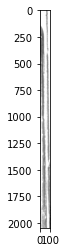

In [6]:
pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni/*.tif'
#pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/*.tif'
pathFS = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScarti/*.tif'
pathScarti = '/Users/leonardoaggio/Desktop/Dataset/S606C/Scarti/*.tif'

pezziXimmagine = 1
border = 30
#Nclusters = 10

results = []
img_results = []
list_paths = []



list_paths = glob.glob(pathBuoni) 
count = 0
for img_path in list_paths:
    img = cv2.imread(img_path)
    try:
        img_results +=  divideImage(cutWorkSpace(img,border),pezziXimmagine)
        count += 1
    except:
        print('errore lettura')

results += [0] * count * pezziXimmagine



list_paths = glob.glob(pathFS)
count = 0
for img_path in list_paths:
    img = cv2.imread(img_path)
    try:
        img_results += divideImage(cutWorkSpace(img,border),pezziXimmagine)
        count += 1
    except:
        print('errore lettura')
        
results += [0] * count * pezziXimmagine

list_paths = glob.glob(pathScarti)
count = 0
for img_path in list_paths:
    img = cv2.imread(img_path)
    try:
        img_results += divideImage(cutWorkSpace(img,border),pezziXimmagine)
        count += 1
    except:
        print('errore lettura')
        
results += [1] * count * pezziXimmagine

#####
# ORA HO IMG_RESULTS & RESULTS
plt.imshow(img_results[1])
plt.show()

In [7]:
#orb
#num_features = 32
#sift
num_features = 128 

In [8]:
df,cols = dataCreation(img_results,results,num_features)

128


In [9]:
#file_name = 'dataframeORB.csv'
#df.to_pickle(file_name) 

In [10]:
#df = pd.read_pickle(file_name)


In [11]:
components = 32

In [12]:
cols = []
for i in range(num_features):
    cols.append('F'+str(i+1))

cols.append('R')

In [15]:

finalDf, pca, cols2, scaler = PCA_SIFT(df,cols,num_features,components)

In [21]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.neural_network import MLPClassifier

def createNN(imgsWithClass, Nclusters,pca):
    sift = cv2.xfeatures2d.SIFT_create()
    #orb = cv2.ORB_create()   
    results = imgsWithClass[0]

    keypoints = []
    descriptors = []
    dico = []
    for img in results:
        keypoints_temp, descriptors_temp = sift.detectAndCompute(img, None)
        #keypoints_temp, descriptors_temp = orb.detectAndCompute(img, None)
        keypoints.append(keypoints_temp)
        descriptors.append(descriptors_temp)
        descriptors_temp = scaler.transform(descriptors_temp)
        temp_pca = pca.transform(descriptors_temp)
        for d in temp_pca:
            dico.append(d)        
    k = np.size(Nclusters) * 10
    batch_size = 256*4
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, verbose=1).fit(dico)
    
    length = len(results)

    # 80% di train 20% di validation
    #train_index = (length // 10) * 8
    train_index = length - 1 
    train_imgs = results[:train_index]
    validation_imgs = results[train_index:]
    
    # creo histogramma con valori trovati di feature per ogni immagine di train
    kmeans.verbose = False
    histo_list = []

    for img in train_imgs:
        kp, des = sift.detectAndCompute(img, None)
        #kp, des = orb.detectAndCompute(img,None)
        histo = np.zeros(k)
        nkp = np.size(kp)
        # Only the training data are used to fit the scaler transformation,
        des = scaler.transform(des)
        temp_pca = pca.transform(des)
        for d in temp_pca:
            idx = kmeans.predict([d])
            histo[idx] += 1/nkp # Because we need normalized histograms, I prefere to add 1/nkp directly

        histo_list.append(histo)
    #creo X_train e Y_train
    X_train = np.array(histo_list)  
    Y_train = imgsWithClass[1][:train_index]
    mlp = MLPClassifier(verbose=True, max_iter=600000,hidden_layer_sizes=1000, alpha=0.0001)
    mlp.fit(X_train, Y_train)
    
    Y_val = imgsWithClass[1][train_index:]
    val_result = []
    i = 0 
    for img in validation_imgs: 
        kp, des = sift.detectAndCompute(img, None)
        #kp, des = orb.detectAndCompute(img,None)
        x = np.zeros(k)
        nkp = np.size(kp)
        des = scaler.transform(des)
        temp_pca = pca.transform(des)
        for d in temp_pca:
            idx = kmeans.predict([d])
            x[idx] += 1/nkp #ottengo vettore normalizzato da kmeans
        res = mlp.predict_proba([x])
        row = []
        # predico. salvo probabilità classificazione e unisco risultato vero per verifica
        for e in res[0]:
            row.append(e)
        if row[0] < row[1]:
            val_result.append([row,Y_val[i],"Scarto"])
        else:
            val_result.append([row,Y_val[i]])
        i += 1
    
    return kmeans, mlp, val_result

In [22]:
def testNN(img_test,border,pcs,Nclusters,pca):
    img = cutWorkSpace(img_test,border)
    imgs = divideImage(img,pcs)
    sift = cv2.xfeatures2d.SIFT_create()
    #orb = cv2.ORB_create()   

    k = np.size(Nclusters) * 10
    results = []
    for img in imgs:
        
        kp, des = sift.detectAndCompute(img, None)
        #kp, des = orb.detectAndCompute(img,None)
        x = np.zeros(k)
        nkp = np.size(kp)
        des = scaler.transform(des)
        temp_pca = pca.transform(des)
        for d in temp_pca:
            idx = kmeans.predict([d])
            x[idx] += 1/nkp #ottengo vettore normalizzato da kmeans
        results.append(mlp.predict_proba([x])[0])

        
    return results

In [23]:
imgsWithClass = [img_results,results]


kmeans, mlp, val_result = createNN(imgsWithClass,5 ,pca)

Init 1/3 with method: k-means++
Inertia for init 1/3: 126666.237419
Init 2/3 with method: k-means++
Inertia for init 2/3: 124118.467263
Init 3/3 with method: k-means++
Inertia for init 3/3: 123002.185346
Minibatch iteration 1/4100: mean batch inertia: 40.155057, ewa inertia: 40.155057 
Minibatch iteration 2/4100: mean batch inertia: 40.160495, ewa inertia: 40.155324 
Minibatch iteration 3/4100: mean batch inertia: 40.147186, ewa inertia: 40.154924 
Minibatch iteration 4/4100: mean batch inertia: 43.369565, ewa inertia: 40.312676 
Minibatch iteration 5/4100: mean batch inertia: 39.827820, ewa inertia: 40.288882 
Minibatch iteration 6/4100: mean batch inertia: 38.409237, ewa inertia: 40.196643 
Minibatch iteration 7/4100: mean batch inertia: 38.711151, ewa inertia: 40.123746 
Minibatch iteration 8/4100: mean batch inertia: 39.191431, ewa inertia: 40.077995 
Minibatch iteration 9/4100: mean batch inertia: 39.893450, ewa inertia: 40.068939 
Minibatch iteration 10/4100: mean batch inertia: 

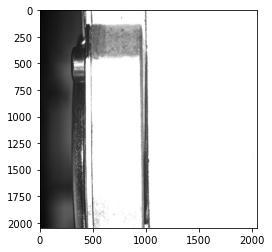

0.7113644591610946
0.28863554083890536


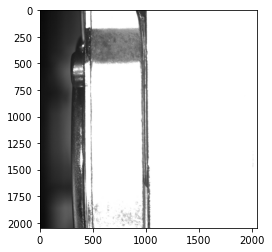

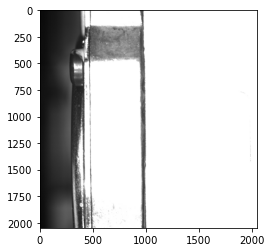

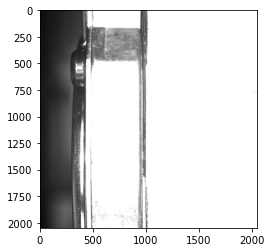

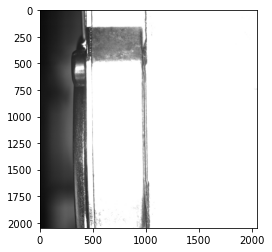

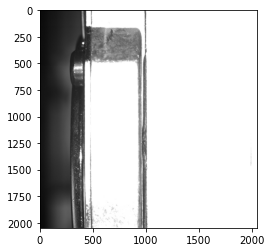

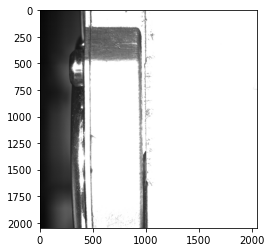

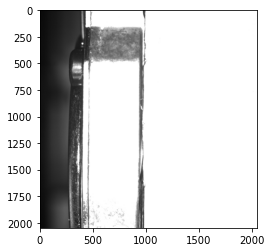

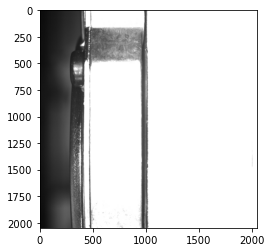

BUONI : 1
Falsi buoni su scarti totali: 0.1111111111111111


In [24]:
temp = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/*.tif'
i = 0
test_path = glob.glob(temp) 
for img_path in test_path:
    img = cv2.imread(img_path)
    plt.imshow(img)
    plt.show()
   #try:
    res = testNN(img,50,1, 5,pca)
    # 1 se orb, 2 se sift
    if len(res) == 1:   
        if res[0][0] > res [0][1]:
            print(res[0][0])
            print(res[0][1])
            i += 1
    else:
        for count in range(len(res)-1):
            if res[count][0] > res[count][1]:
                i += 1
                break
    #except:
    #print('errore nell elaborazione')
print('BUONI : '+ str(i))
print('Falsi buoni su scarti totali: '+ str(i/len(test_path)))

In [25]:
temp = '/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/*.tif'
i = 0
test_path = glob.glob(temp) 
for img_path in test_path:
    img = cv2.imread(img_path)
    #plt.imshow(img)
    #plt.show()
    try:
        res = testNN(img,border,1,5,pca)
        #print(res)
        # 1 se orb, 2 se sift
        if len(res) == 1:   
            if res[0][0] < res [0][1]:
                i += 1
        else:
            for count in range(len(res)-1):
                if res[count][0] < res [count][1]:
                    i += 1
                    break
    except:
        print('errore nell elaborazione')
print('SCARTI : '+ str(i))
print('Falsi scarti su buoni: '+ str(i/len(test_path)))

errore nell elaborazione
errore nell elaborazione
errore nell elaborazione
SCARTI : 43
Falsi scarti su buoni: 0.0979498861047836
